# SED fitting with PROSPECTOR

Based on https://prospect.readthedocs.io/en/latest/quickstart.html

## Import modules and environment variables
This is a notebook that allows you to do SED fitting using known photometry (i.e. obtained via HOSTPHOT)
Assumes that you already have installed Prospector and its dependencies. If you have issues with that, please contact me.

Important: Set the 'HOME_SPS' variable to your fsps instalation

In [1]:
import os
os.environ['SPS_HOME'] = '/Users/cristinajimenezpalau/fsps'

In [2]:
try:
    import fsps
    import dynesty
    import sedpy
    import h5py, astropy
    import numpy as np
    import astroquery
    from prospect.utils.obsutils import fix_obs
    import sedpy
    from sedpy.observate import list_available_filters
    from astropy.coordinates import SkyCoord
    import astropy.wcs as wcs
    import astropy.units as u
    from astropy.cosmology import FlatLambdaCDM
    import matplotlib.pyplot as plt
    from pylab import rcParams
    from matplotlib import rc
    from prospect.models.templates import TemplateLibrary
    from prospect.models import SpecModel
    import prospect.models
    from prospect.models import priors
    from prospect.sources import CSPSpecBasis
    from prospect.sources import FastStepBasis
    from prospect.likelihood import lnlike_spec, lnlike_phot, write_log
    from prospect.fitting import fit_model
    from prospect.models import PolySpecModel
    import prospect.models
    from prospect.fitting import lnprobfn, fit_model

    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)
except RuntimeError:
    print('Remember to set the SPS variable!')

## We import the spectrum
We import the spectrum and its associated errors, and we will transform it to the proper units to enter it to PROSPECTOR. IMPORTANT: when fitting only spectra it doesn't matter if it is observer or rest frame, but if we fit simultaneously spectrum and photometry it has to be on the observed frame.

In [3]:
import pandas as pd

wave=[]
flux=[]
e_flux=[]

target='SN2006gz'
SN_filename=target+'_local_1kpc.txt'
path = '/Users/cristinajimenezpalau/Desktop/prospector_tutorial/restframed_spectra/'+target+'_rest_1kpc.txt'

#We will obtain the spectrum, the error, the wavelengths and the redshift

z=0.023630

print('The redshift of the target is',z)

SN_spectrum = open(path, 'r')
lines = SN_spectrum.readlines()
for line in lines:
    wave.append(float(line.split()[0]))
    flux.append(float(line.split()[1]))
    e_flux.append(float(line.split()[2]))

The redshift of the target is 0.02363


## We import the photometry

In [4]:
import os
import pandas as pd
from sedpy import observate
import pathlib

target='SN2006gz'
path='/Users/cristinajimenezpalau/Desktop/Super-Chandra/images/'+target+'/'

#Since we are interested on doing that analysis. Otherwise switch to global.

analysis='local'

SDSS_filt=[]
PS1_filt=[]
galex_filt=[]
twomass_filt=[]
des_filt=[]
UKIDSS_filt=[]

m_AB=[]
e_mAB=[]


#The apperture in case of local analysis. In case of global this value does not exist.

ap=str(0.5)

#We find the files ending in local, since we are interested on doing that analysis. Otherwise switch to global.
analysis='local'

files=[f for f in os.listdir(path) if f.endswith(analysis+".csv")]
print('The existing HOSTPHOT photometry files for the target' ,target,  'are',str(files))
files=np.array(files)
if all(x in files for x in ['DES_'+analysis+'.csv', 'PS1_'+analysis+'.csv'])==True:
    new_files = np.delete(files,np.where(files == 'DES_'+analysis+'.csv'))
elif all(x in files for x in ['2MASS_'+analysis+'.csv', 'UKIDSS_'+analysis+'.csv'])==True:
    new_files = np.delete(files,np.where(files == '2MASS_'+analysis+'.csv'))
else:
    new_files=files
print('')
print('The loaded HOSTPHOT photometry files are',new_files)
print('')
df = pd.concat((pd.read_csv(path+f,index_col=False) for f in new_files), axis=0)


#We obtain the redshift. In case of the global analysis, we will use the local files to get the redshift.

if analysis=='global':
    files=[f for f in os.listdir(path) if f.endswith("local.csv")]
    print('The existing HOSTPHOT photometry files for the target' ,target,  'are',str(files))
    df1 = pd.concat((pd.read_csv(path+f,index_col=False) for f in new_files), axis=0)
    z=np.array(df1['redshift'])
    z_obs=z[0]
    print('')
    print('The known redshift is:',z_obs) #The value is repeated in all the tables, we take the first
else:
    z=np.array(df['redshift'])
    z_obs=z[0]
    print('')
    print('The known redshift is:',z_obs) #The value is repeated in all the tables, we take the first

#We check which surveys are available

all_surveys=np.array(df.survey)
print('')
print('The available surveys are:', str(all_surveys))

if any("SDSS" in surveys for surveys in all_surveys):
    SDSS_bands=['u']
    if analysis=='local':
        u=np.array(df['u_'+ap]); e_u=np.array(df['u_'+ap+'_err'])
    else:
        u=np.array(df['u']); e_u=np.array(df['u_err'])
    u = u[~np.isnan(u)];e_u=e_u[~np.isnan(e_u)]
    if u.size == 0:
        print('')
        print('The photometry in the PS1 filter', band, 'does not exist')
    else:            
        SDSS_filt = ['sdss_'+filt+'0' for filt in SDSS_bands]
    print('The magnitude and the error for the SDSS u band are:', float(u), float(e_u))

if any("PS1" in surveys for surveys in all_surveys):   
    PS1_bands=['g','r','i','z','y']
    PS1_mags=[]
    e_PS1_mags=[]
    PS1_filt=[]    

    for band in PS1_bands:
        if analysis=='local':
            PS1_mag=np.array(df[band+'_'+ap]);e_PS1_mag=np.array(df[band+'_'+ap+'_err'])
        else:
            PS1_mag=np.array(df[band]);e_PS1_mag=np.array(df[band+'_err'])
        PS1_mag = PS1_mag[~np.isnan(PS1_mag)];e_PS1_mag=e_PS1_mag[~np.isnan(e_PS1_mag)]
        if PS1_mag.size == 0:
            print('')
            print('The photometry in the PS1 filter', band, 'does not exist')
            PS1_bands = np.delete(PS1_bands, np.where(PS1_bands == band))
        else:
            PS1_mags.append(float(PS1_mag))
            e_PS1_mags.append(float(e_PS1_mag))
            PS1 = observate.Filter("PS1_"+band, directory="/Users/cristinajimenezpalau/Desktop/PROSPECTOR/")
            PS1_filt.append(PS1)
            
    print('The magnitude and the error for the PS1 g,r,i,z,y bands are:', PS1_mags, e_PS1_mags)

if any("UKIDSS" in surveys for surveys in all_surveys):   
    UKIDSS_bands=['Y','Z','H','J','K']
    UKIDSS_corr=[0.528,0.634,0.938,1.379,1.9]
    index_corr=[0,1,2,3,4]
    UKIDSS_mags=[]
    e_UKIDSS_mags=[]
    UKIDSS_filt=[]    

    for band,i in zip(UKIDSS_bands,index_corr):
        if analysis=='local':
            UKIDSS_mag=np.array(df[band+'_'+ap]);e_UKIDSS_mag=np.array(df[band+'_'+ap+'_err'])
            UKIDSS_mag=UKIDSS_mag+UKIDSS_corr[i]
            print('Converted Vega to AB magnitude for', band)
        else:
            UKIDSS_mag=np.array(df[band]);e_UKIDSS_mag=np.array(df[band+'_err'])
            UKIDSS_mag=UKIDSS_mag+UKIDSS_corr[i]
        UKIDSS_mag = UKIDSS_mag[~np.isnan(UKIDSS_mag)];e_UKIDSS_mag=e_UKIDSS_mag[~np.isnan(e_UKIDSS_mag)]
        if UKIDSS_mag.size == 0 or e_UKIDSS_mag>=1:
            print('')
            print('The photometry in the UKIDSS filter', band, 'does not exist or does not pass quality cuts')
            UKIDSS_bands = np.delete(UKIDSS_bands, np.where(UKIDSS_bands == band))
        else:
            UKIDSS_mags.append(float(UKIDSS_mag))
            e_UKIDSS_mags.append(float(e_UKIDSS_mag))
            UKIDSS = observate.Filter("UKIDSS_"+band, directory="/Users/cristinajimenezpalau/Desktop/PROSPECTOR/")
            UKIDSS_filt.append(UKIDSS)
            
    print('The magnitude and the error for the UKIDSS H,Y,Z,H,J,K bands are:', UKIDSS_mags, e_UKIDSS_mags)

if any("GALEX" in surveys for surveys in all_surveys):   
    galex_bands=['FUV','NUV']
    galex_mags=[]
    e_galex_mags=[]  
    galex_filt=[]

    for band in galex_bands:
        if analysis=='local':
            galex_mag=np.array(df[band+'_'+ap]);e_galex_mag=np.array(df[band+'_'+ap+'_err'])
        else:
            galex_mag=np.array(df[band]);e_galex_mag=np.array(df[band+'_err'])
        galex_mag = galex_mag[~np.isnan(galex_mag)];e_galex_mag=e_galex_mag[~np.isnan(e_galex_mag)]
        if galex_mag.size == 0 or e_galex_mag>=1:
            print('')
            print('The photometry in the GALEX filter', band, 'does not exist')
            galex_bands = np.delete(galex_bands, np.where(galex_bands == band))
        else:
            galex_mags.append(float(galex_mag))
            e_galex_mags.append(float(e_galex_mag))
            galex='galex_'+band
            galex_filt.append(galex)
    print('')
    print('The magnitude and the error for the GALEX FUV and NUV bands are:', galex_mags, e_galex_mags)

        
if any("2MASS" in surveys for surveys in all_surveys):  
    
    twomass_bands=['J','H','Ks']
    twomass_corr=[0.910,1.390,1.850]
    index_corr=[0,1,2]
    twomass_mags=[]
    e_twomass_mags=[]
    twomass_filt=[]
    
    for band,i in zip(twomass_bands,index_corr):
        if analysis=='local':
            twomass_mag=np.array(df[band+'_'+ap]);e_twomass_mag=np.array(df[band+'_'+ap+'_err'])
            twomass_mag=twomass_mag+twomass_corr[i]
            print('Converted Vega to AB Magnitude for', band)
        else:
            twomass_mag=np.array(df[band]);e_twomass_mag=np.array(df[band+'_err'])
            twomass_mag=twomass_mag+twomass_corr[i]
            print('Converted Vega to AB Magnitude for', band)
        twomass_mag = twomass_mag[~np.isnan(twomass_mag)];e_twomass_mag=e_twomass_mag[~np.isnan(e_twomass_mag)]
        if twomass_mag.size == 0 or e_twomass_mag>=1:
            print('')
            print('The photometry in the 2MASS filter', band, 'does not exist or does not pass quality cuts!')
            twomass_bands = np.delete(twomass_bands, np.where(twomass_bands == band))
        else:
            twomass_mags.append(float(twomass_mag))
            e_twomass_mags.append(float(e_twomass_mag))
            twomass='twomass_'+band
            twomass_filt.append(twomass)
    print('')
    print('The magnitude and the error for the 2MASS J, H and Ks bands are:', twomass_mags, e_twomass_mags)
        

if any("DES" in surveys for surveys in all_surveys):   
    des_bands=['g','r','i','z','Y']
    des_mags=[]
    e_des_mags=[]
    des_filt=[]
        
    for band in des_bands:
        if analysis=='local':
            des_mag=np.array(df[band+'_'+ap]);e_des_mag=np.array(df[band+'_'+ap+'_err'])
        else:
            des_mag=np.array(df[band]);e_des_mag=np.array(df[band+'_err'])
        des_mag = des_mag[~np.isnan(des_mag)];e_des_mag=e_des_mag[~np.isnan(e_des_mag)]
        if des_mag.size == 0 or e_des_mag>=1:
            print('')
            print('The photometry in the DES filter', band, 'does not pass the quality cuts')
            des_bands = np.delete(des_bands, np.where(des_bands == band))
        else:
            des_mags.append(float(des_mag))
            e_des_mags.append(float(e_des_mag))
            DES='decam_'+band
            des_filt.append(DES)
            
    print('')
    print('The magnitude and the error for the DES g, r, i, z bands are:', des_mags, e_des_mags)
    
#Now we will create the input arrays for STARLIGHT    

filters_list=[]
if len(SDSS_filt)!=0:
    filters_list=SDSS_filt
    m_AB=np.array(u)
    e_mAB=np.array(e_u)
if len(galex_filt)!=0:
    filters_list+=galex_filt
    m_AB=np.concatenate((m_AB,galex_mags))
    e_mAB=np.concatenate((e_mAB,e_galex_mags))
if len(twomass_filt)!=0:
    filters_list+=twomass_filt
    m_AB=np.concatenate((m_AB,twomass_mags))
    e_mAB=np.concatenate((e_mAB,e_twomass_mags))
if len(des_filt)!=0:
    filters_list+=des_filt
    m_AB=np.concatenate((m_AB,des_mags))
    e_mAB=np.concatenate((e_mAB,e_des_mags))
if len(PS1_filt)!=0:
    m_AB=np.concatenate((m_AB,PS1_mags))
    e_mAB=np.concatenate((e_mAB,e_PS1_mags))
if len(UKIDSS_filt)!=0:
    m_AB=np.concatenate((m_AB,UKIDSS_mags))
    e_mAB=np.concatenate((e_mAB,e_UKIDSS_mags))
    
print('')
if len(des_filt)!=0:
    print('The filters loaded for',target, 'are:',filters_list,des_filt)
else:
    print('The filters loaded for',target, 'are:',filters_list)
print('')
print('The magnitudes loaded for', target,'are',m_AB)
print('')
print('The errors loaded for',target,'are',e_mAB)
print('')
                
#Now you have float values of the u filter and arrays corresponding to the magnituds and errors per each band.
#IMPORTANT! The order matters, depending on the index of the array you have certain filter!
#Then you can just append this values into one array, (mAB and eMAB) by the same order that you import the filters
   

                
#Now you have float values of the u filter and arrays corresponding to the magnituds and errors per each band.
#IMPORTANT! The order matters, depending on the index of the array you have certain filter!
#Then you can just append this values into one array, (mAB and eMAB) by the same order that you import the filters  

The existing HOSTPHOT photometry files for the target SN2006gz are ['SkyMapper_local.csv', 'PS1_local.csv', 'GALEX_local.csv', '2MASS_local.csv']

The loaded HOSTPHOT photometry files are ['SkyMapper_local.csv' 'PS1_local.csv' 'GALEX_local.csv' '2MASS_local.csv']


The known redshift is: 0.02363

The available surveys are: ['SkyMapper' 'PS1' 'GALEX' '2MASS']
The magnitude and the error for the PS1 g,r,i,z,y bands are: [22.144007628394064, 22.040819991223284, 22.037282255759678, 21.947992609407347, 21.703376359211436] [0.0625912595212037, 0.0864858529775672, 0.0706489381768523, 0.1604736487870613, 0.3047238081671106]

The photometry in the GALEX filter FUV does not exist

The magnitude and the error for the GALEX FUV and NUV bands are: [23.028805362659376] [0.5607656759796001]
Converted Vega to AB Magnitude for J

The photometry in the 2MASS filter J does not exist or does not pass quality cuts!
Converted Vega to AB Magnitude for H

The photometry in the 2MASS filter H does not exist or

Now we obtain the luminosity distance, needed for spectral fits.

In [5]:
from astropy.coordinates import SkyCoord
import astropy.wcs as wcs
import astropy.units as u
import numpy as np
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)
z_red=0.023630
lum_distance=cosmo.luminosity_distance(z_red)
lum_distance=np.array(lum_distance)
lum_distance=lum_distance*10**6


print('')
print('The luminosity distance is', lum_distance)


The luminosity distance is 103039029.33870544


## We generate the obs dictionary
The first step that you need to do to fit a SED with PROSPECTOR is to generate the 'obs' dictionary.
In this dictionary we will store our observables. In our case, it will be redshift, fluxes and its uncertainties. All the observed fluxes need to be transformed into maggies, so we perform the conversion and store it at the dictionary.

This observable dictionary also allows you to add photometry values and its uncertainties, in case you want to fit photometry or spectrum+photometry. Since this is not the case, we fix the keys "wavelenght" and "spectrum" to None.

{'filters': [<class 'sedpy.observate.Filter'>(galex_NUV), <class 'sedpy.observate.Filter'>(PS1_g), <class 'sedpy.observate.Filter'>(PS1_r), <class 'sedpy.observate.Filter'>(PS1_i), <class 'sedpy.observate.Filter'>(PS1_z), <class 'sedpy.observate.Filter'>(PS1_y)], 'phot_wave': array([2271.12579359, 4814.28808341, 6174.34957128, 7515.76770146,
       8663.63218297, 9616.86645988]), 'redshift': 0.02363, 'maggies': array([6.14437700e-10, 1.38802391e-09, 1.52641282e-09, 1.53139455e-09,
       1.66265811e-09, 2.08280905e-09]), 'maggies_unc': array([3.17270324e-10, 7.99983103e-11, 1.21559037e-10, 9.96237560e-11,
       2.45683991e-10, 5.84421276e-10]), 'wavelength': array([3016., 3017., 3018., ..., 6004., 6005., 6006.]), 'spectrum': array([5.15732845e-10, 3.87806441e-10, 2.21976932e-10, ...,
       3.47632549e-10, 7.39375361e-10, 7.29888443e-10]), 'unc': array([2.82602081e-09, 2.92257036e-09, 2.92546019e-09, ...,
       1.50667873e-09, 1.55216543e-09, 1.58394518e-09]), 'mask': array([ True,  

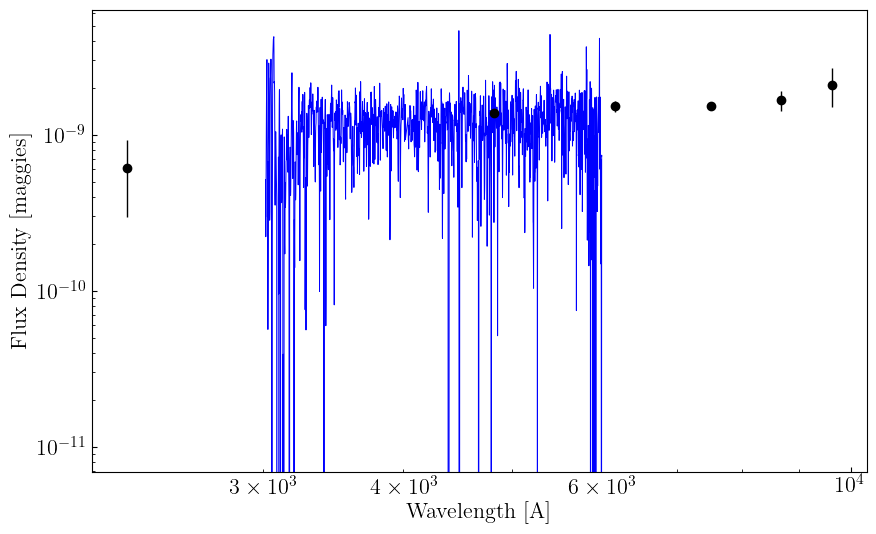

In [6]:
from prospect.utils.obsutils import fix_obs
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import rc
from sedpy import observate
    
#We will turn the input into proper units    
    
obs={}

z_red=0.023630


wave=np.array(wave)
flux=np.array(flux)
e_flux=np.array(e_flux)
        
Jy_flux=3.34*(10**4)*(wave)**2*flux
mag_flux=Jy_flux/3631
e_Jy_flux=3.34*(10**4)*(wave)**2*e_flux
e_mag_flux=e_Jy_flux/3631

filters=observate.load_filters(filters_list)
filters_list+=PS1_filt
filters_list+=UKIDSS_filt

if len(PS1_filt)!=0:
    filters+=PS1_filt
    
if len(UKIDSS_filt)!=0:
    filters+=UKIDSS_filt
    
obs['filters']=filters
obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])
obs['redshift']=z_red

#Then we load the magnitudes using a .txt file or using an array.
#IMPORTANT: The input that we provide to the dictionary has to follow the same order
#as the list of filters.

m_AB=np.array(m_AB)
e_mAB=np.array(e_mAB)

obs["maggies"] = 10**(-0.4*m_AB)


e_mAB=e_mAB*10**(-0.4*m_AB)/1.086
#e_mAB[(e_mAB < e_floor*m_AB)] = e_floor*m_AB[(e_mAB < e_floor*m_AB)]

obs["maggies_unc"]=e_mAB


wave_rest = wave / (1+obs['redshift'])
mask = ((e_mag_flux != 0) &
            (mag_flux != 0) &
            (wave_rest < 7500) &
            (np.abs(wave_rest-5892.9) > 25) &
            (np.abs(wave_rest-3935.0) > 10))

    
obs['wavelength'] = wave[mask]
obs['spectrum'] = mag_flux[mask]
obs['unc']=e_mag_flux[mask]
obs['mask']=np.ones(mask.sum(), dtype=bool)
      
obs=fix_obs(obs)
print(obs)
    
#Plotting settings (from Jimenez-Palau et al. 2022)

rc('font', size=16)  
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rcParams['figure.figsize'] = 10, 6
plt.rc('grid', color='gray', linestyle=':')
plt.rc('xtick', direction='in', color='black')
plt.rc('ytick', direction='in', color='black')

    
smask = obs['mask']
plt.plot(obs['wavelength'][smask], obs['spectrum'][smask], '-', lw=0.7, color='blue')
plt.errorbar(obs["phot_wave"],  obs["maggies"], yerr=obs["maggies_unc"], color="k",linestyle="",linewidth=1,marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.savefig(path+target+'obs_values_center.pdf')
plt.show()

## We build the model 
Then, the next step is to create the model to describe our stellar populations. Since PROSPECTOR uses a bayesian approach, this means that we need to add aproppiate initial values and priors per each science case.
This initial values will describe what we assume for the redshift, the ages of the stellar populations, and the Star Formation Rates.
In this case we will use a non-parametric (Star Formation History) SFH + the fixed value for the redshift. 
See https://prospect.readthedocs.io/en/latest/sfhs.html for more details.

In [7]:
import prospect.models
from prospect.models.templates import TemplateLibrary
from prospect.models import SpecModel
from prospect.models import priors

# input basic continuity SFH
model_params = TemplateLibrary["continuity_sfh"]

# fit for redshift
# use catalog value as center of the prior
z=0.023630
model_params["zred"]['isfree'] = False
model_params["zred"]["init"] =  z
#model_params["zred"]["prior"] = priors.TopHat(mini=z-0.01, maxi=z+0.01)

# modify to increase nbins
nbins_sfh = 5
model_params['agebins']['N'] = nbins_sfh
model_params['mass']['N'] = nbins_sfh
model_params['logsfr_ratios']['N'] = nbins_sfh-1
model_params['logsfr_ratios']['init'] = np.full(nbins_sfh-1,0.0) # constant SFH
model_params['logsfr_ratios']['prior'] = priors.StudentT(mean=np.full(nbins_sfh-1,0.0),
                                                                      scale=np.full(nbins_sfh-1,0.3),
                                                                      df=np.full(nbins_sfh-1,2))
    # add redshift scaling to agebins, such that
    # t_max = t_univ
def zred_to_agebins(zred=None,agebins=None,**extras):
        tuniv = cosmo.age(zred).value[0]*1e9
        tbinmax = (tuniv*0.9)
        agelims = [0.0,7.4772] + np.linspace(8.0,np.log10(tbinmax),nbins_sfh-2).tolist() + [np.log10(tuniv)]
        agebins = np.array([agelims[:-1], agelims[1:]])
        return agebins.T

def logmass_to_masses(logmass=None, logsfr_ratios=None, zred=None, **extras):
        agebins = zred_to_agebins(zred=zred)
        logsfr_ratios = np.clip(logsfr_ratios,-10,10) # numerical issues...
        nbins = agebins.shape[0]
        sratios = 10**logsfr_ratios
        dt = (10**agebins[:,1]-10**agebins[:,0])
        coeffs = np.array([ (1./np.prod(sratios[:i])) * (np.prod(dt[1:i+1]) / np.prod(dt[:i])) for i in range(nbins)])
        m1 = (10**logmass) / coeffs.sum()
        return m1 * coeffs

model_params['agebins']['depends_on'] = zred_to_agebins
model_params['mass']['depends_on'] = logmass_to_masses

    # metallicity (no mass-metallicity prior yet!)
model_params["logzsol"]["prior"] = priors.TopHat(mini=-1.0, maxi=0.19)

    # complexify the dust
model_params['dust_type']['init'] = 4
model_params["dust2"]["prior"] = priors.ClippedNormal(mini=0.0, maxi=4.0, mean=0.3, sigma=1)
model_params["dust_index"] = {"N": 1, 
                                  "isfree": True,
                                  "init": 0.0, "units": "power-law multiplication of Calzetti",
                                  "prior": priors.TopHat(mini=-1.0, maxi=0.4)}

def to_dust1(dust1_fraction=None, dust1=None, dust2=None, **extras):
        return dust1_fraction*dust2

model_params['dust1'] = {"N": 1, 
                             "isfree": False, 
                             'depends_on': to_dust1,
                             "init": 0.0, "units": "optical depth towards young stars",
                             "prior": None}
model_params['dust1_fraction'] = {'N': 1,
                                      'isfree': True,
                                      'init': 1.0,
                                      'prior': priors.ClippedNormal(mini=0.0, maxi=2.0, mean=1.0, sigma=0.3)}

    # velocity dispersion
model_params.update(TemplateLibrary['spectral_smoothing'])
model_params["sigma_smooth"]["prior"] = priors.TopHat(mini=40.0, maxi=400.0)

    # Change the model parameter specifications based on some keyword arguments
add_duste=False
extra_phot=False
if (add_duste) & (extra_phot):
        # Add dust emission (with fixed dust SED parameters)
        model_params.update(TemplateLibrary["dust_emission"])
        model_params['duste_gamma']['isfree'] = False
        model_params['duste_qpah']['isfree'] = True
        model_params['duste_gamma']['init'] = 0.01
        model_params['duste_qpah']['prior'] = priors.TopHat(mini=0.5, maxi=7.0)
        model_params['duste_umin']['isfree'] = False
        
add_agn=False
extra_phot=False    
if add_agn & (extra_phot):
        # Allow for the presence of an AGN in the mid-infrared
        model_params.update(TemplateLibrary["agn"])
        model_params['fagn']['isfree'] = True
        model_params['fagn']['prior'] = priors.LogUniform(mini=1e-5, maxi=3.0)
        model_params['agn_tau']['isfree'] = True
        model_params['agn_tau']['prior'] = priors.LogUniform(mini=5.0, maxi=150.)
add_neb=True
if add_neb:
        # Add nebular emission
        model_params.update(TemplateLibrary["nebular"])
        model_params['gas_logu']['isfree'] = True
        model_params['gas_logz']['isfree'] = True
        model_params['nebemlineinspec'] = {'N': 1,
                                           'isfree': False,
                                           'init': False}
        _ = model_params["gas_logz"].pop("depends_on")
        
marginalize_neb=False
if marginalize_neb:
            model_params.update(TemplateLibrary['nebular_marginalization'])
            #model_params.update(TemplateLibrary['fit_eline_redshift'])
            model_params['eline_prior_width']['init'] = 1.0
            model_params['use_eline_prior']['init'] = True

            # only marginalize over a few (strong) emission lines
            # The allowed names of the emission lines are in $SPS_HOME/data/emlines_info.dat
            if False:
                to_fit = ['H delta 4102', 'H gamma 4340', '[OIII]4364', 'HeI 4472','H beta 4861','[OIII]4960','[OIII]5007','[ArIII]5193',
                          '[NII]6549','H alpha 6563','[NII]6585','[SII]6717','[SII]6732']
                model_params['lines_to_fit']['init'] = to_fit

            # model_params['use_eline_prior']['init'] = False
            else:
                model_params['nebemlineinspec']['init'] = True

    # This removes the continuum from the spectroscopy. Highly recommend
    # using when modeling both photometry & spectroscopy
remove_spec_continuum=True
if remove_spec_continuum:
        model_params.update(TemplateLibrary['optimize_speccal'])
        model_params['spec_norm']['isfree'] = False
        model_params["polyorder"]["init"] = 12

    # This is a pixel outlier model. It helps to marginalize over
    # poorly modeled noise, such as residual sky lines or
    # even missing absorption lines
    #Consider using outlier phot?
mixture_model=False
if mixture_model:
        model_params['f_outlier_spec'] = {"N": 1, 
                                          "isfree": True, 
                                          "init": 0.01,
                                          "prior": priors.TopHat(mini=1e-5, maxi=0.5)}
        model_params['nsigma_outlier_spec'] = {"N": 1, 
                                              "isfree": False, 
                                              "init": 50.0}
        model_params['f_outlier_phot'] = {"N": 1, 
                                          "isfree": False, 
                                          "init": 0.00,
                                          "prior": priors.TopHat(mini=0, maxi=0.5)}
        model_params['nsigma_outlier_phot'] = {"N": 1, 
                                              "isfree": False, 
                                              "init": 50.0}


    # This is a multiplicative noise inflation term. It inflates the noise in
    # all spectroscopic pixels as necessary to get a good fit.
model_params['spec_jitter'] = {"N": 1, 
                                   "isfree": True, 
                                   "init": 1.0,
                                   "prior": priors.TopHat(mini=1.0, maxi=3.0)}


#Very important! If we don't add this by default the fitted lines may be too wide

model_params['eline_sigma'] = {'N': 1, 'isfree': True,
                                       'init': 100.0, 'units': r'km/s',
                                       'prior': priors.TopHat(mini=20, maxi=400)}        

# Now instantiate the model using this new dictionary of parameter specifications
    #model = PolySpecModel(model_params) This is for phot+spectrum!!
model= PolySpecModel(model_params)
 

In [8]:
sps = FastStepBasis(zcontinuous=1)

In [9]:
noise_model = (None, None)

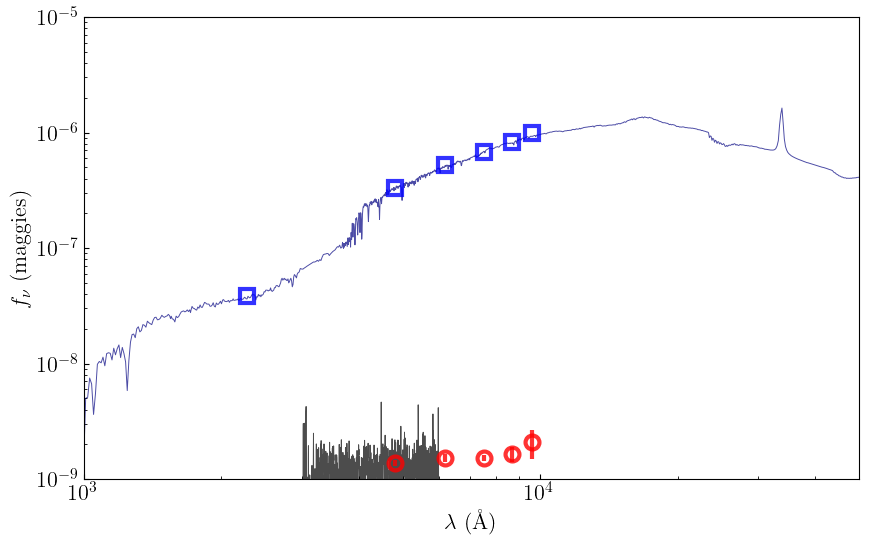

In [10]:
# Generate the model SED at the initial value of theta
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.predict(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) 
                       for p in model.free_params])
 
#We need to do that to get the full SED for photometry too
obs_copy = obs.copy()
obs_copy['spectrum'] = None
obs_copy['wavelength'] = None

initial_spec_copy, _, _ = model.predict(theta, obs=obs_copy, sps=sps)

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths

ap=str(1)

wphot = obs["phot_wave"]

obs_spec=obs['spectrum']
# spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]
    
wspec_copy=sps.wavelengths
wspec_copy *= a
    
rc('font', size=16)  
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rcParams['figure.figsize'] = 10, 6
plt.rc('grid', color='gray', linestyle=':')
plt.rc('xtick', direction='in', color='black')
plt.rc('ytick', direction='in', color='black')
    
plt.loglog(wspec_copy, initial_spec_copy, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
plt.loglog(wspec, obs_spec, label='Observed spectrum', 
       lw=0.7, color='black', alpha=0.7)
plt.errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
plt.xlim(1000, 50000)
plt.ylim(10**(-9),10**(-5))
plt.ylabel(r"$f_\nu$ (maggies)")
plt.xlabel(r"$\lambda$ (\AA)")
plt.savefig(path+target+'_'+ap+'_arcsec_specphot_emcee_model.pdf', format='pdf')

In [11]:
# --- start minimization ----
run_params={}
run_params["dynesty"] = False
run_params["emcee"] = False
run_params["optimize"] = True
run_params["min_method"] = 'lm'
# We'll start minimization from "nmin" separate places, 
# the first based on the current values of each parameter and the 
# rest drawn from the prior.  Starting from these extra draws 
# can guard against local minima, or problems caused by 
# starting at the edge of a prior (e.g. dust2=0.0)
run_params["nmin"] = 8

output = fit_model(obs, model, sps, lnprobfn=lnprobfn,noise=noise_model, **run_params)

print("Done optimization in {}s".format(output["optimization"][1]))

/Users/cristinajimenezpalau/anaconda3/envs/prospector2/lib/python3.8/site-packages/prospect/models/priors.py:117: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)


Done optimization in 108.47656917572021s


[-5.77277477e-01  4.20699794e-01  7.41902579e+00 -7.68451112e-01
 -2.31062098e-01 -6.09387078e-03 -5.74321655e-01 -2.86450466e-02
  1.37895385e+00  3.53312450e+02 -5.12492252e-01 -3.20670741e+00
  1.32670916e+00  3.99999502e+02]
3
[-5.77277477e-01  4.20699794e-01  7.41902579e+00 -7.68451112e-01
 -2.31062098e-01 -6.09387078e-03 -5.74321655e-01 -2.86450466e-02
  1.37895385e+00  3.53312450e+02 -5.12492252e-01 -3.20670741e+00
  1.32670916e+00  3.99999502e+02]


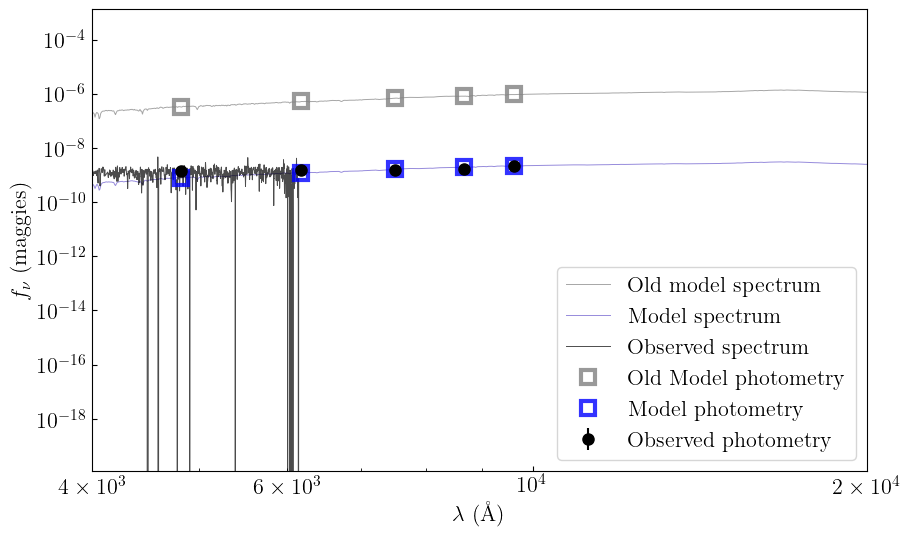

In [13]:
print(model.theta)
(results, topt) = output["optimization"]
# Find which of the minimizations gave the best result, 
# and use the parameter vector for that minimization
ind_best = np.argmin([r.cost for r in results])
print(ind_best)
theta_best = results[ind_best].x.copy()
print(theta_best)

#Remember we need a copy to see the model properly!
obs_copy = obs.copy()
obs_copy['spectrum'] = None
obs_copy['wavelength'] = None

pspec_copy, pphot_copy, _ = model.mean_model(theta_best, obs_copy, sps=sps)
wspec_copy=sps.wavelengths
wspec_copy *= a

# plot Data, best fit model, and old models
plt.loglog(wspec_copy, initial_spec_copy, label='Old model spectrum',
       lw=0.7, color='gray', alpha=0.7)
plt.loglog(wspec_copy, pspec_copy, label='Model spectrum', 
       lw=0.7, color='slateblue', alpha=0.7)
plt.loglog(wspec*a, obs_spec, label='Observed spectrum', 
       lw=0.7, color='black', alpha=0.7)
plt.errorbar(wphot, initial_phot, label='Old Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='gray', 
         markeredgewidth=3)
plt.errorbar(wphot, pphot_copy, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
         label='Observed photometry', 
         marker='o', markersize=8, ls='',color='k')
plt.ylabel(r"$f_\nu$ (maggies)")
plt.xlabel(r"$\lambda$ (\AA)")
plt.xlim(4e3,2e4)
plt.legend()
plt.savefig(path+target+'_'+ap+'arcsec_specphot_emcee_optimization.pdf', format='pdf')

In [14]:
# Set this to False if you don't want to do another optimization
# before emcee sampling (but note that the "optimization" entry 
# in the output dictionary will be (None, 0.) in this case)
# If set to true then another round of optmization will be performed 
# before sampling begins and the "optmization" entry of the output
# will be populated.
run_params["optimize"] = False
run_params["emcee"] = True
run_params["dynesty"] = False
# Number of emcee walkers
run_params["nwalkers"] = 128
# Number of iterations of the MCMC sampling
run_params["niter"] = 1024
# Number of iterations in each round of burn-in
# After each round, the walkers are reinitialized based on the 
# locations of the highest probablity half of the walkers.
run_params["nburn"] = [16, 32, 64]

output = fit_model(obs, model, sps, lnprobfn=lnprobfn, noise=noise_model, **run_params)

print('done emcee in {0}s'.format(output["sampling"][1]))

number of walkers=128


/Users/cristinajimenezpalau/anaconda3/envs/prospector2/lib/python3.8/site-packages/prospect/models/priors.py:117: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)


done burn #0 (16 iterations)
done burn #1 (32 iterations)
done burn #2 (64 iterations)
number of walkers=128
starting production
done production
done emcee in 5835.302471876144s


In [15]:
from prospect.io import write_results as writer
fit_type='emcee'
hfile = path+target+"_specphot_dust_mcmc.h5"
writer.write_hdf5(hfile, run_params, model, obs,
                 output["sampling"][0], output["optimization"][0],
                 sps=sps,
                 tsample=output["sampling"][1],
                 toptimize=output["optimization"][1])

/Users/cristinajimenezpalau/anaconda3/envs/prospector2/lib/python3.8/site-packages/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/Users/cristinajimenezpalau/anaconda3/envs/prospector2/lib/python3.8/site-packages/prospect/io/write_results.py:290: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/Users/cristinajimenezpalau/anaconda3/envs/prospector2/lib/python3.8/site-packages/prospect/io/write_results.py:49: RuntimeWarning: Could not obtain prospector version info
  warnings.warn("Could not obtain prospector version info", RuntimeWarning)


In [16]:
import prospect.io.read_results as reader
results_type = "emcee"

out, out_obs,out_model = reader.results_from(path+target+"_specphot_dust_mcmc.h5".format(results_type))
print(out_model)    

None


In [17]:
theta_best=out["bestfit"]

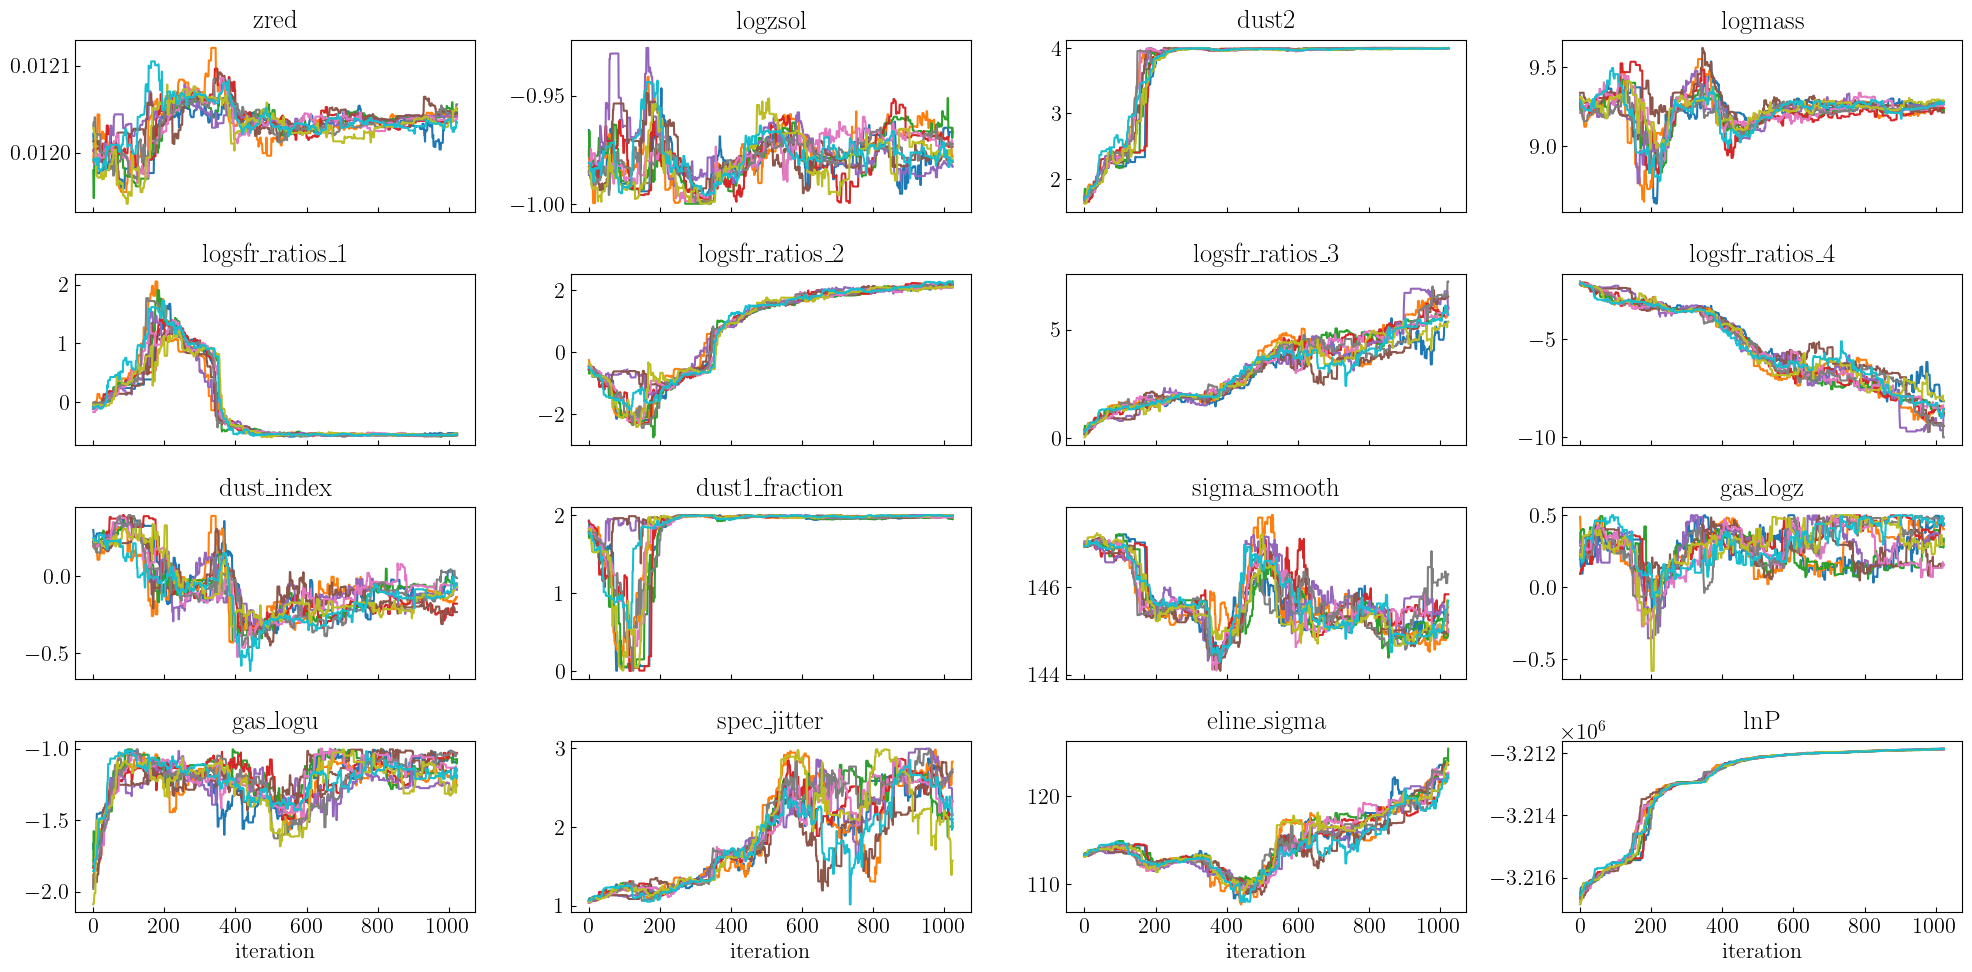

In [60]:
chosen = np.random.choice(out["run_params"]["nwalkers"], size=10, replace=False)
tracefig = reader.traceplot(out, figsize=(20,10), chains=chosen)

[ 0.37115407  0.70251073 -0.06342892 -1.64296515 -0.62744912  0.23852587]


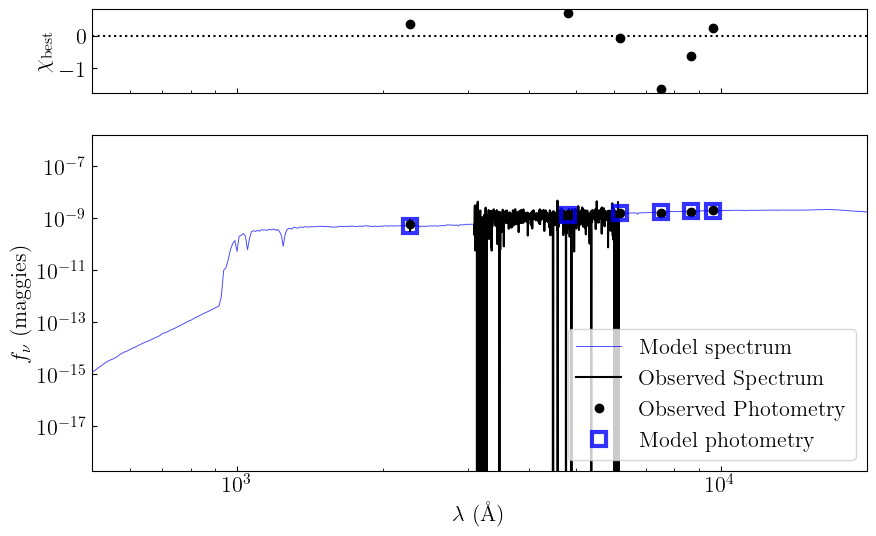

In [18]:
randint = np.random.randint
imax = np.argmax(out['lnprobability'])
if results_type == "emcee":
    i, j = np.unravel_index(imax, out['lnprobability'].shape)
    theta_max = out['chain'][i, j, :].copy()
    thin = 5

nwalkers=128
niter=1024
theta = out['chain'][randint(nwalkers), randint(niter)]
    
obs_copy = obs.copy()
obs_copy['spectrum'] = None
obs_copy['wavelength'] = None


pwave = out_obs["phot_wave"]

mspec_map, mphot_map, _ = model.mean_model(theta, obs=obs_copy, sps=sps)
wspec_copy=sps.wavelengths
wspec_copy *= a

rc('font', size=16)  
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rcParams['figure.figsize'] = 10, 6
plt.rc('grid', color='gray', linestyle=':')
plt.rc('xtick', direction='in', color='black')
plt.rc('ytick', direction='in', color='black')


import matplotlib.pyplot as plt
sfig, saxes = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[1,4]), sharex=True)
ax = saxes[1]
pwave = out_obs["phot_wave"]
# plot the data

ax.set_ylabel(r"$f_\nu$ (maggies)")
ax.set_xlabel(r"$\lambda$ (\AA)")
ax.set_yscale("log")

ax.loglog(wspec_copy, mspec_map, label='Model spectrum',
       lw=0.7, color='blue', alpha=0.7)
ax.errorbar(wphot, mphot_map, label='Model photometry',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
ax.plot(out_obs["wavelength"]*(1+out_obs["redshift"]), out_obs["spectrum"], color="black", label="Observed Spectrum")
ax.plot(pwave, out_obs["maggies"], linestyle="", marker="o", color="k",label="Observed Photometry")
ax.errorbar(pwave,  out_obs["maggies"], out_obs["maggies_unc"], linestyle="", color="k", zorder=10)
ax.set_xlim(5e2,2e4)
ax.legend()

ax = saxes[0]
chi = (out_obs["maggies"] - mphot_map) / out_obs["maggies_unc"]
print(chi)
ax.plot(pwave, chi, linestyle="", marker="o", color="k")
ax.axhline(0, color="k", linestyle=":")
ax.set_ylabel(r"$\chi_{\rm best}$")


plt.savefig(path+target+'_'+ap+'_arcsec_emcee_specphot_bestfitspectrum.pdf', format='pdf')
